In [30]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! mamba install -c conda-forge jupyterlab mpi4py
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 

from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sys import platform

## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [2]:
if platform == "darwin":
    data_dir = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    file_signature = "kp.turbine.z02.b0.20220301.*.wt073.nc"
    multiprocessor = None
elif platform == "linux":
    data_dir = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    file_signature = "kp.turbine.z02.b0.*.*.*.nc"
    multiprocessor = "mpi"

data_loader = DataLoader(data_dir=data_dir, file_signature=file_signature, multiprocessor=multiprocessor, 
                         features=["time", "turbine_id", "turbine_status", "turbine_availability", "wind_direction", "wind_speed", "power_output", "nacelle_direction"])

In [3]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

NetCDF File: kp.turbine.z02.b0.20220301.000000.wt073.nc

Global Attributes:

Dimensions:
  date: 240237
  string7: 7

Variables:
  Flag:
    Dimensions: ('date', 'string7')
    Shape: (240237, 7)
    Data type: |S1
    Attributes:
      _Encoding: utf-8
  date:
    Dimensions: ('date',)
    Shape: (240237,)
    Data type: int32
    Attributes:
      units: milliseconds since 2022-03-01 00:00:01.499000
      calendar: proleptic_gregorian
  WCNV.GnA1:
    Dimensions: ('date',)
    Shape: (240237,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnA2:
    Dimensions: ('date',)
    Shape: (240237,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnA3:
    Dimensions: ('date',)
    Shape: (240237,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnPNV1:
    Dimensions: ('date',)
    Shape: (240237,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnPNV2:
    Dimensions: ('date',)
    Shape: (240237,)
    Data ty

In [4]:
df = data_loader.read_multi_netcdf()
df

Processed /Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.z02.b0.20220301.000000.wt073.nc, shape: (44708, 26)
Combined DataFrame shape: (44708, 26)
Unique turbine IDs: shape: (1,)
Series: 'turbine_id' [str]
[
	"wt073"
]


shape: (44_708, 26)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time      ┆ turbine_i ┆ generator ┆ generator ┆ … ┆ rotor_spe ┆ turbine_s ┆ wind_dire ┆ wind_spe │
│ ---       ┆ d         ┆ _current_ ┆ _current_ ┆   ┆ ed        ┆ tatus     ┆ ction     ┆ ed       │
│ datetime[ ┆ ---       ┆ phase_1   ┆ phase_2   ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ns]       ┆ str       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2022-03-0 ┆ wt073     ┆ 780.1045  ┆ 790.9797  ┆ … ┆ 9.708984  ┆ null      ┆ null      ┆ 6.374405 │
│ 1 00:00:0 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 1.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ 257.0     ┆ null     │
│ 1 00:00:0 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 5.046     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ 791.09533 ┆ 800.9753  ┆ … ┆ 9.748992  ┆ null      ┆ null      ┆ 6.519901 │
│ 1 00:00:0 ┆           ┆ 7         ┆           ┆   ┆           ┆           ┆           ┆          │
│ 7.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ 253.0     ┆ null     │
│ 1 00:00:1 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 0.077     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 1 00:00:1 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 0.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2022-03-0 ┆ wt073     ┆ 348.76806 ┆ 353.51785 ┆ … ┆ 7.467866  ┆ null      ┆ null      ┆ null     │
│ 1 23:59:5 ┆           ┆ 6         ┆ 3         ┆   ┆           ┆           ┆           ┆          │
│ 3.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 1 23:59:5 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ 237.0     ┆ null     │
│ 1 23:59:5 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 6.833     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ 341.7204  ┆ 348.14105 ┆ … ┆ 7.457289  ┆ null      ┆ null      ┆ 5.280187 │
│ 1 23:59:5 ┆           ┆           ┆ 2         ┆   ┆           ┆           ┆           ┆          │
│ 8.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2022-03-0 ┆ wt073     ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 1 23:59:5 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 9.499     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
df = data_loader.reduce_features()
df

shape: (34_636, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ null      ┆ null      ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ null      ┆ null      ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.29072   ┆ null      ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ null      ┆ null      ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ null      ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ null      ┆ null      ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

## Remove Inoperational Turbine Rows, Interpolate Null Data

In [6]:
data_filter = DataFilter(raw_df=df, turbine_availability_col="turbine_availability", turbine_status_col="turbine_status")
df = data_filter.filter_inoperational(status_codes=[1], availability_codes=[100], include_nan=True)
df


shape: (34_594, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ null      ┆ null      ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ null      ┆ null      ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.29072   ┆ null      ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ null      ┆ null      ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ null      ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ null      ┆ null      ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

In [7]:
df = data_filter.resolve_missing_data(features=["wind_speed", "wind_direction", "power_output", "nacelle_direction"])
df

shape: (34_594, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ 6.460418  ┆ 941.40848 ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆ 9         ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 255.04969 ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆ 2         ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ 6.460303  ┆ 946.13715 ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 252.13192 ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.12719 ┆ 5.29072   ┆ 401.44371 ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆ 3         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ 5.29024   ┆ 401.66501 ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 238.99441 ┆ 5.287711  ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆ 7         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ 5.282694  ┆ 398.37388 ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆ 5         ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

## Plot Wind Farm, Data Distributions

In [8]:
turbine_input_filepath = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
farm_input_filepath = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
data_inspector = DataInspector(df=df, turbine_input_filepath=turbine_input_filepath, farm_input_filepath=farm_input_filepath)

In [9]:
# data_inspector.plot_wind_farm()

  warnings.warn(



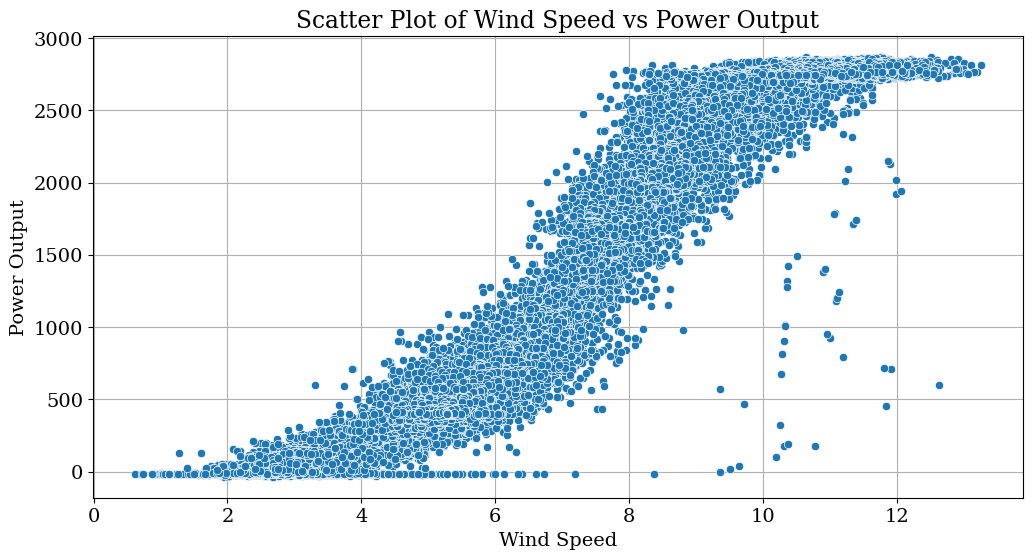

In [10]:
data_inspector.plot_wind_speed_power(turbine_ids=["wt073"])

  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)



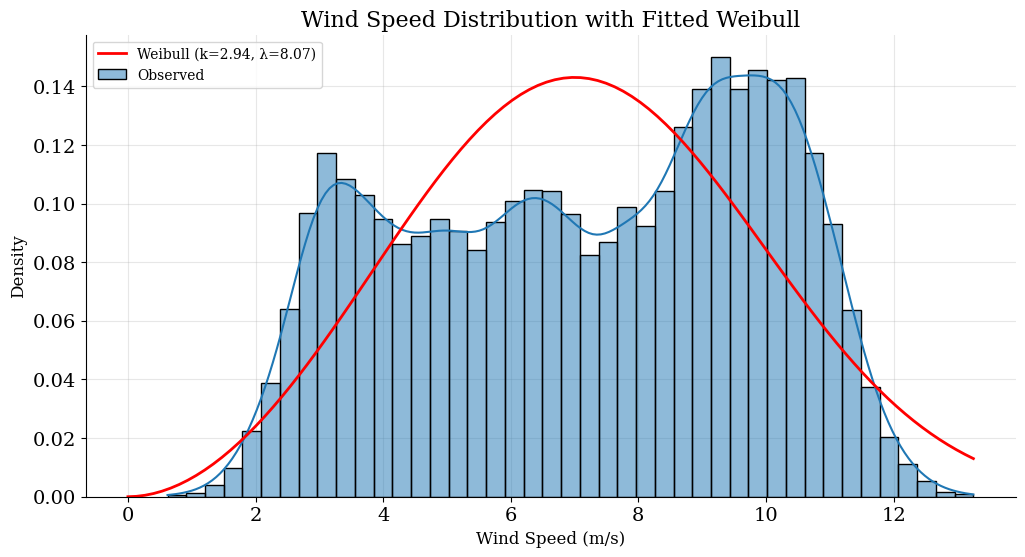

Weibull shape parameter (k): 2.94
Weibull scale parameter (λ): 8.07


In [11]:
data_inspector.plot_wind_speed_weibull(turbine_ids=["wt073"])

<Figure size 1000x1000 with 0 Axes>

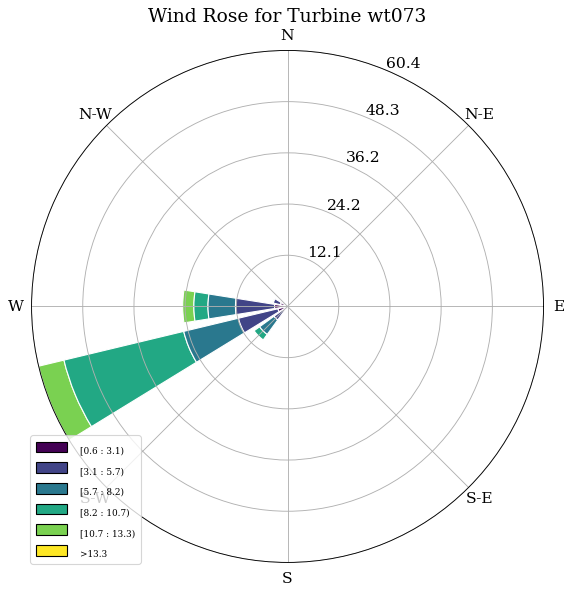

In [12]:
data_inspector.plot_wind_rose(turbine_ids=["wt073"])

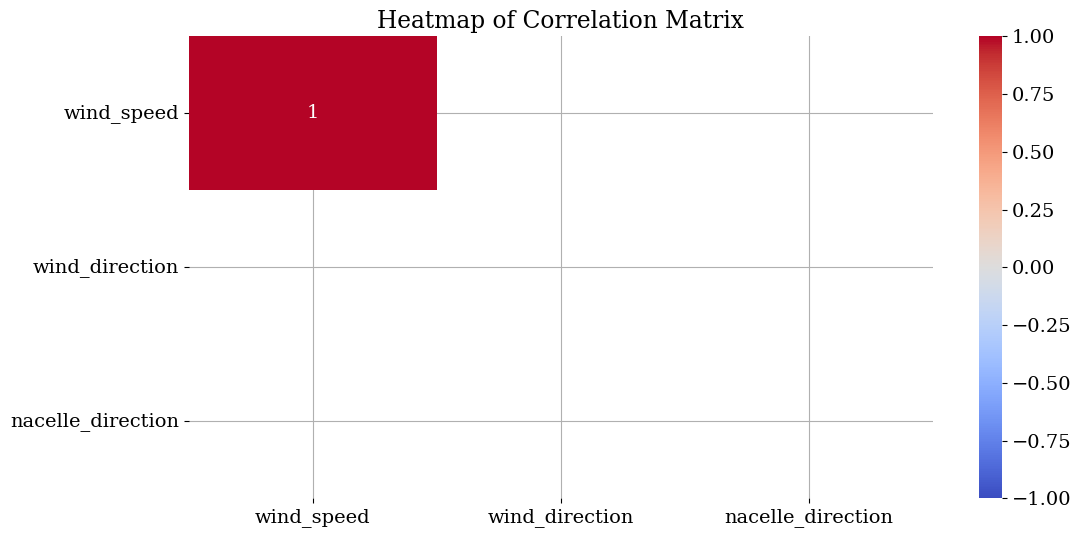

In [13]:
data_inspector.plot_correlation(["wind_speed", "wind_direction", "nacelle_direction"])

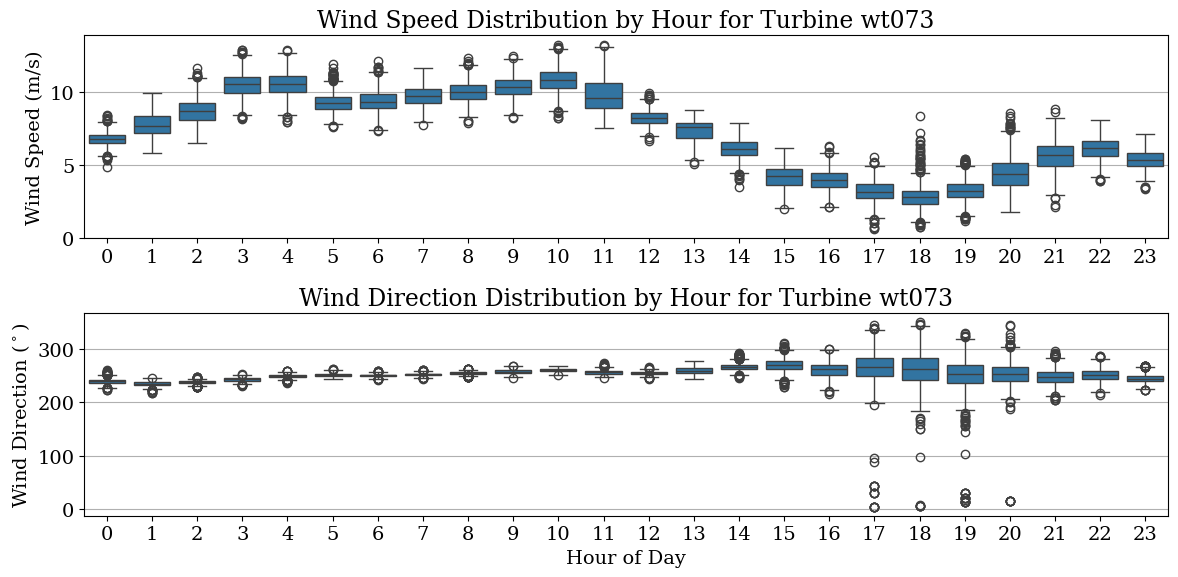

In [14]:
data_inspector.plot_boxplot_wind_speed_direction(turbine_ids=["wt073"])

In [15]:
# from types import MethodType
# data_inspector.plot_time_series = MethodType(plot_time_series, data_inspector)
#data_inspector.plot_time_series(turbine_ids=["wt073"])

## OpenOA Data Preparation & Inspection

In [16]:
print(f"Features of interest = {data_loader.features}")
print(f"Available features = {df.columns}")
desc_df = qa.describe(df.to_pandas())
desc_df.loc[desc_df.index.isin(data_loader.features)]

Features of interest = ['time', 'turbine_id', 'turbine_status', 'turbine_availability', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['time', 'turbine_id', 'turbine_status', 'turbine_availability', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']


count                           mean  \
time                    34594  2022-03-01 12:11:26.186194176   
turbine_status          187.0                            1.0   
turbine_availability    187.0                          100.0   
wind_direction        34592.0                     252.954728   
wind_speed            34594.0                       7.178585   
power_output          34594.0                    1440.385647   
nacelle_direction     34376.0                     256.477421   

                                             min  \
time                  2022-03-01 00:00:01.499000   
turbine_status                               1.0   
turbine_availability                       100.0   
wind_direction                               5.0   
wind_speed                              0.620715   
power_output                          -35.707897   
nacelle_direction                          208.0   

                                                25%  \
time                  2022-03-01 06:06:05.671749888   
turbine_status                                  1.0   
turbine_availability                          100.0   
wind_direction                                244.0   
wind_speed                                 4.785576   
power_output                             331.959218   
nacelle_direction                        249.998394   

                                                50%  \
time                  2022-03-01 12:16:51.755500032   
turbine_status                                  1.0   
turbine_availability                          100.0   
wind_direction                                253.0   
wind_speed                                 7.430257   
power_output                             1387.48291   
nacelle_direction                        256.267479   

                                                75%  \
time                  2022-03-01 18:20:20.030249984   
turbine_status                                  1.0   
turbine_availability                          100.0   
wind_direction                                260.0   
wind_speed                                 9.578946   
power_output                            2611.167593   
nacelle_direction                        262.497253   

                                             max          std  
time                  2022-03-01 23:59:58.499000          NaN  
turbine_status                               1.0          0.0  
turbine_availability                       100.0          0.0  
wind_direction                             350.0    17.380789  
wind_speed                             13.251008     2.755505  
power_output                            2870.624  1079.737257  
nacelle_direction                          300.0    12.232776

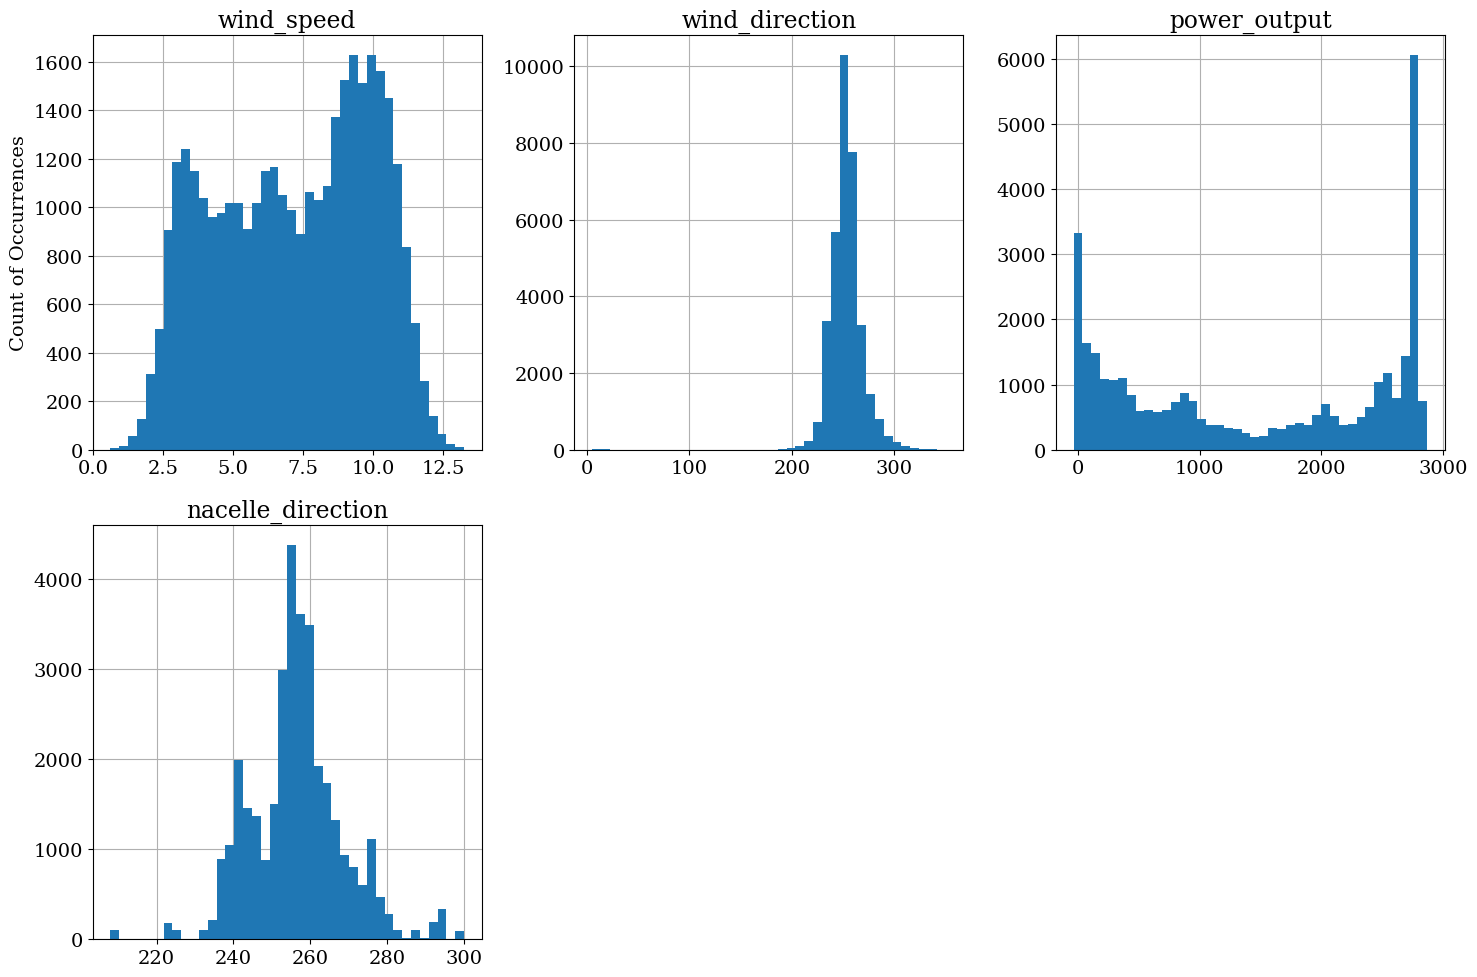

In [17]:
plot.column_histograms(df.select(["wind_speed", "wind_direction", "power_output", "nacelle_direction"]).select(cs.numeric()).to_pandas())

## OpenOA Filtering

### Wind Speed Range Filter

In [18]:
# check for wind speed values that are outside of the acceptable range
out_of_range = filters.range_flag(df["wind_speed"].to_pandas(), lower=0, upper=70)
df["wind_speed"].filter(pl.Series(out_of_range))

shape: (0,)
Series: 'wind_speed' [f64]
[
]

### Power Curve Window Range Filter

In [19]:
# apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s.
out_of_window = filters.window_range_flag(window_col=df["wind_speed"].to_pandas(), window_start=5., window_end=40., 
                                          value_col=df["power_output"].to_pandas(), value_min=20., value_max=3000.)
df.select(["wind_speed", "power_output"]).filter(pl.Series(out_of_window))

shape: (25, 2)
┌────────────┬──────────────┐
│ wind_speed ┆ power_output │
│ ---        ┆ ---          │
│ f64        ┆ f64          │
╞════════════╪══════════════╡
│ 9.363695   ┆ -4.070775    │
│ 9.512499   ┆ 17.783124    │
│ 5.091065   ┆ -17.176365   │
│ 5.410366   ┆ -16.35845    │
│ 5.506545   ┆ -16.690363   │
│ …          ┆ …            │
│ 5.99399    ┆ -16.322067   │
│ 5.054244   ┆ -17.162193   │
│ 5.695046   ┆ -17.287216   │
│ 5.03715    ┆ -13.861887   │
│ 5.283698   ┆ -13.998443   │
└────────────┴──────────────┘

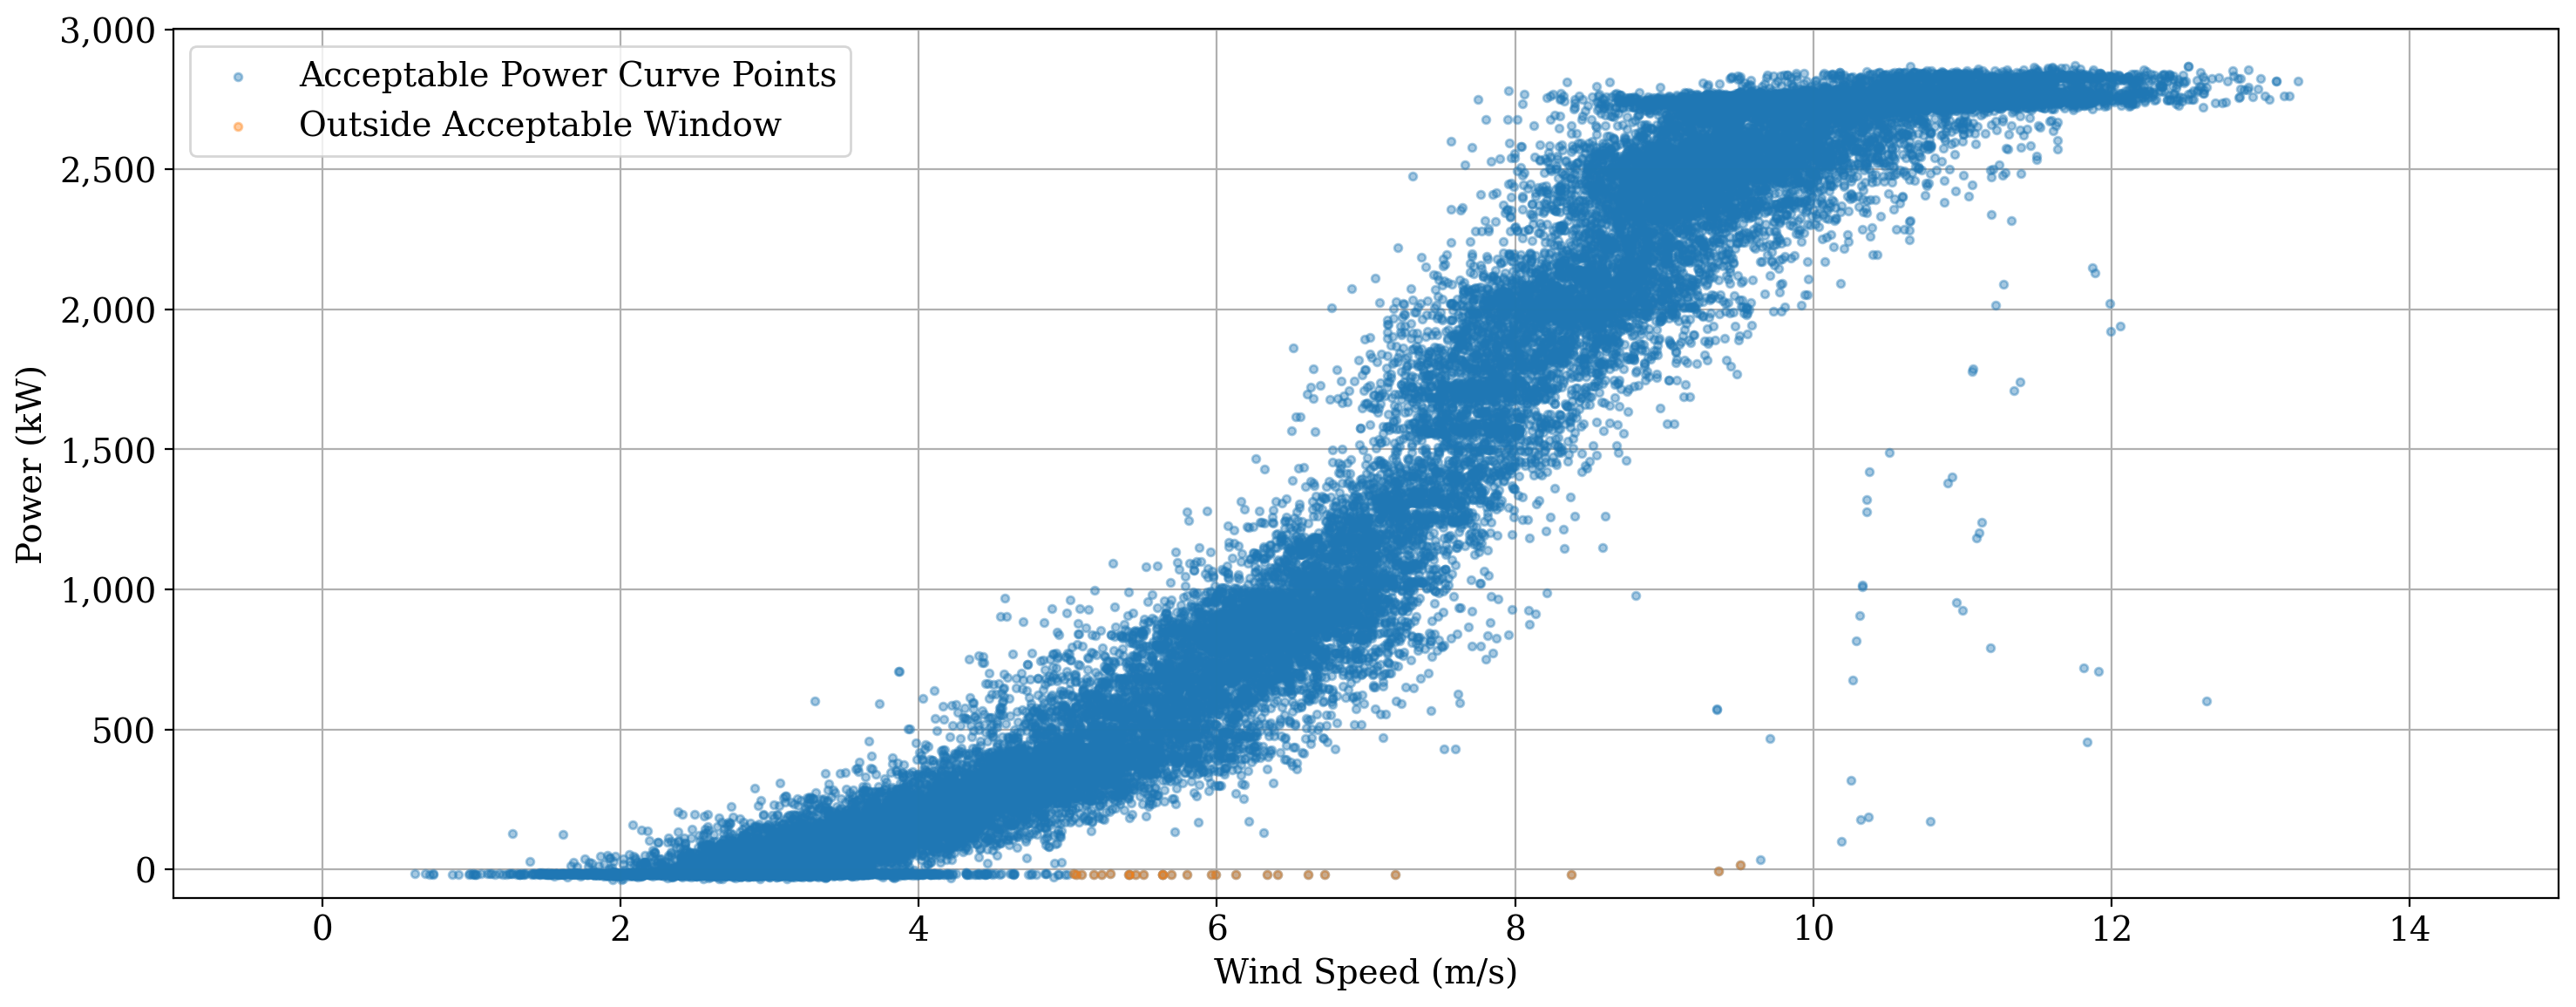

In [20]:
# plot values that are outside of power-wind speed range
plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=out_of_window,
    flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
    xlim=(-1, 15),
    ylim=(-100, 3000),
    legend=True,
    scatter_kwargs=dict(alpha=0.4, s=10)
)

In [21]:
# remove rows corresponding to values that are outside of power-wind speed window range
df = df.filter(pl.Series(~out_of_window))
df

shape: (34_569, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ 6.460418  ┆ 941.40848 ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆ 9         ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 255.04969 ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆ 2         ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ 6.460303  ┆ 946.13715 ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 252.13192 ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.12719 ┆ 5.29072   ┆ 401.44371 ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆ 3         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ 5.29024   ┆ 401.66501 ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 238.99441 ┆ 5.287711  ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆ 7         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ 5.282694  ┆ 398.37388 ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆ 5         ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

### Power Curve Bin Filter

In [22]:

# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed
max_bin = 0.90 * df["power_output"].max()
bin_outliers = filters.bin_filter(bin_col=df["power_output"].to_pandas(), 
                                  value_col=df["wind_speed"].to_pandas(), 
                                  bin_width=100, threshold=1.5,
                                  center_type="median", 
                                  bin_min=20., bin_max=max_bin,
                                  threshold_type="scalar", direction="above", # TODO above or below?
                                  )
qa.describe(df.select(["wind_speed", "power_output"]).filter(pl.Series(bin_outliers)).to_pandas())

count         mean         std        min         25%  \
wind_speed    139.0     9.169763    2.307073   4.840958    7.105666   
power_output  139.0  1237.383989  920.091926  22.448230  382.820331   

                     50%          75%          max  
wind_speed     10.327196    11.055330    12.636008  
power_output  954.916900  2284.203372  2577.965820

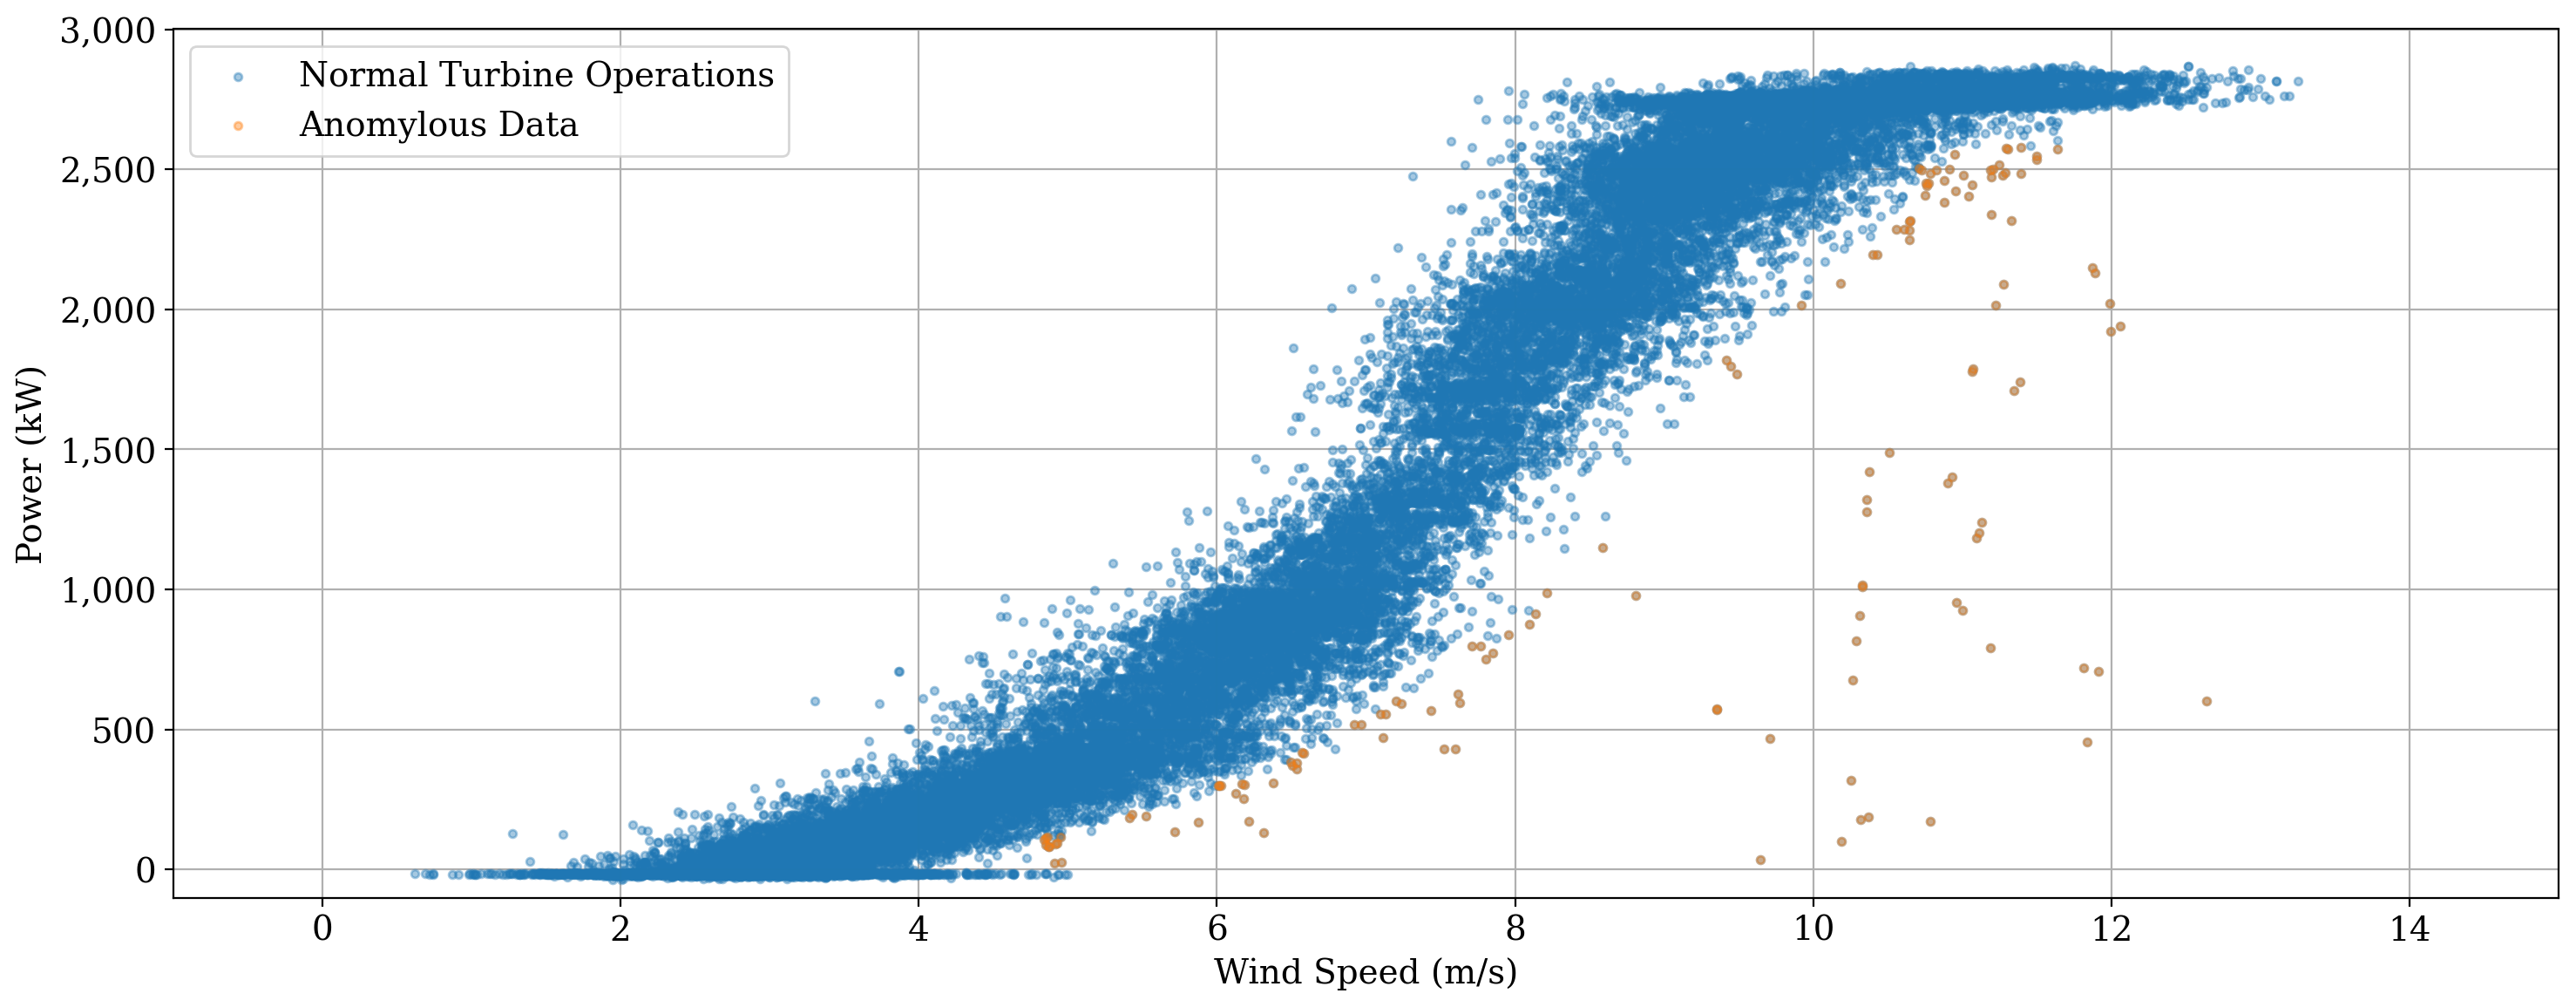

In [23]:
# plot values outside the power-wind speed bin filter
plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=bin_outliers,
    flag_labels=("Anomylous Data", "Normal Turbine Operations"),
    xlim=(-1, 15),
    ylim=(-100, 3000),
    legend=True,
    scatter_kwargs=dict(alpha=0.4, s=10)
)

In [24]:
# remove rows corresponding to values that are outside of power-wind speed bins 
df = df.filter(pl.Series(~bin_outliers))
df

shape: (34_430, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ 6.460418  ┆ 941.40848 ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆ 9         ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 255.04969 ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆ 2         ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ 6.460303  ┆ 946.13715 ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 252.13192 ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.12719 ┆ 5.29072   ┆ 401.44371 ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆ 3         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ 5.29024   ┆ 401.66501 ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 238.99441 ┆ 5.287711  ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆ 7         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ 5.282694  ┆ 398.37388 ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆ 5         ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

### Unresponsive Sensor Filter

In [25]:
ws_frozen_sensor = filters.unresponsive_flag(data=df["wind_speed"].to_pandas(), threshold=3)
wd_frozen_sensor = filters.unresponsive_flag(data=df["wind_direction"].to_pandas(), threshold=3)
pwr_frozen_sensor = filters.unresponsive_flag(data=df["power_output"].to_pandas(), threshold=3)
qa.describe(pl.concat([df.select(["wind_speed"]).filter(pl.Series(ws_frozen_sensor)),
                      df.select(["wind_direction"]).filter(pl.Series(wd_frozen_sensor)),
                      df.select(["power_output"]).filter(pl.Series(pwr_frozen_sensor))], how="horizontal").to_pandas())

count      mean        std  min  25%   50%   75%   max
wind_speed        0.0       NaN        NaN  NaN  NaN   NaN   NaN   NaN
wind_direction   42.0  19.47619  12.570267  5.0  8.0  15.0  30.0  44.0
power_output      0.0       NaN        NaN  NaN  NaN   NaN   NaN   NaN

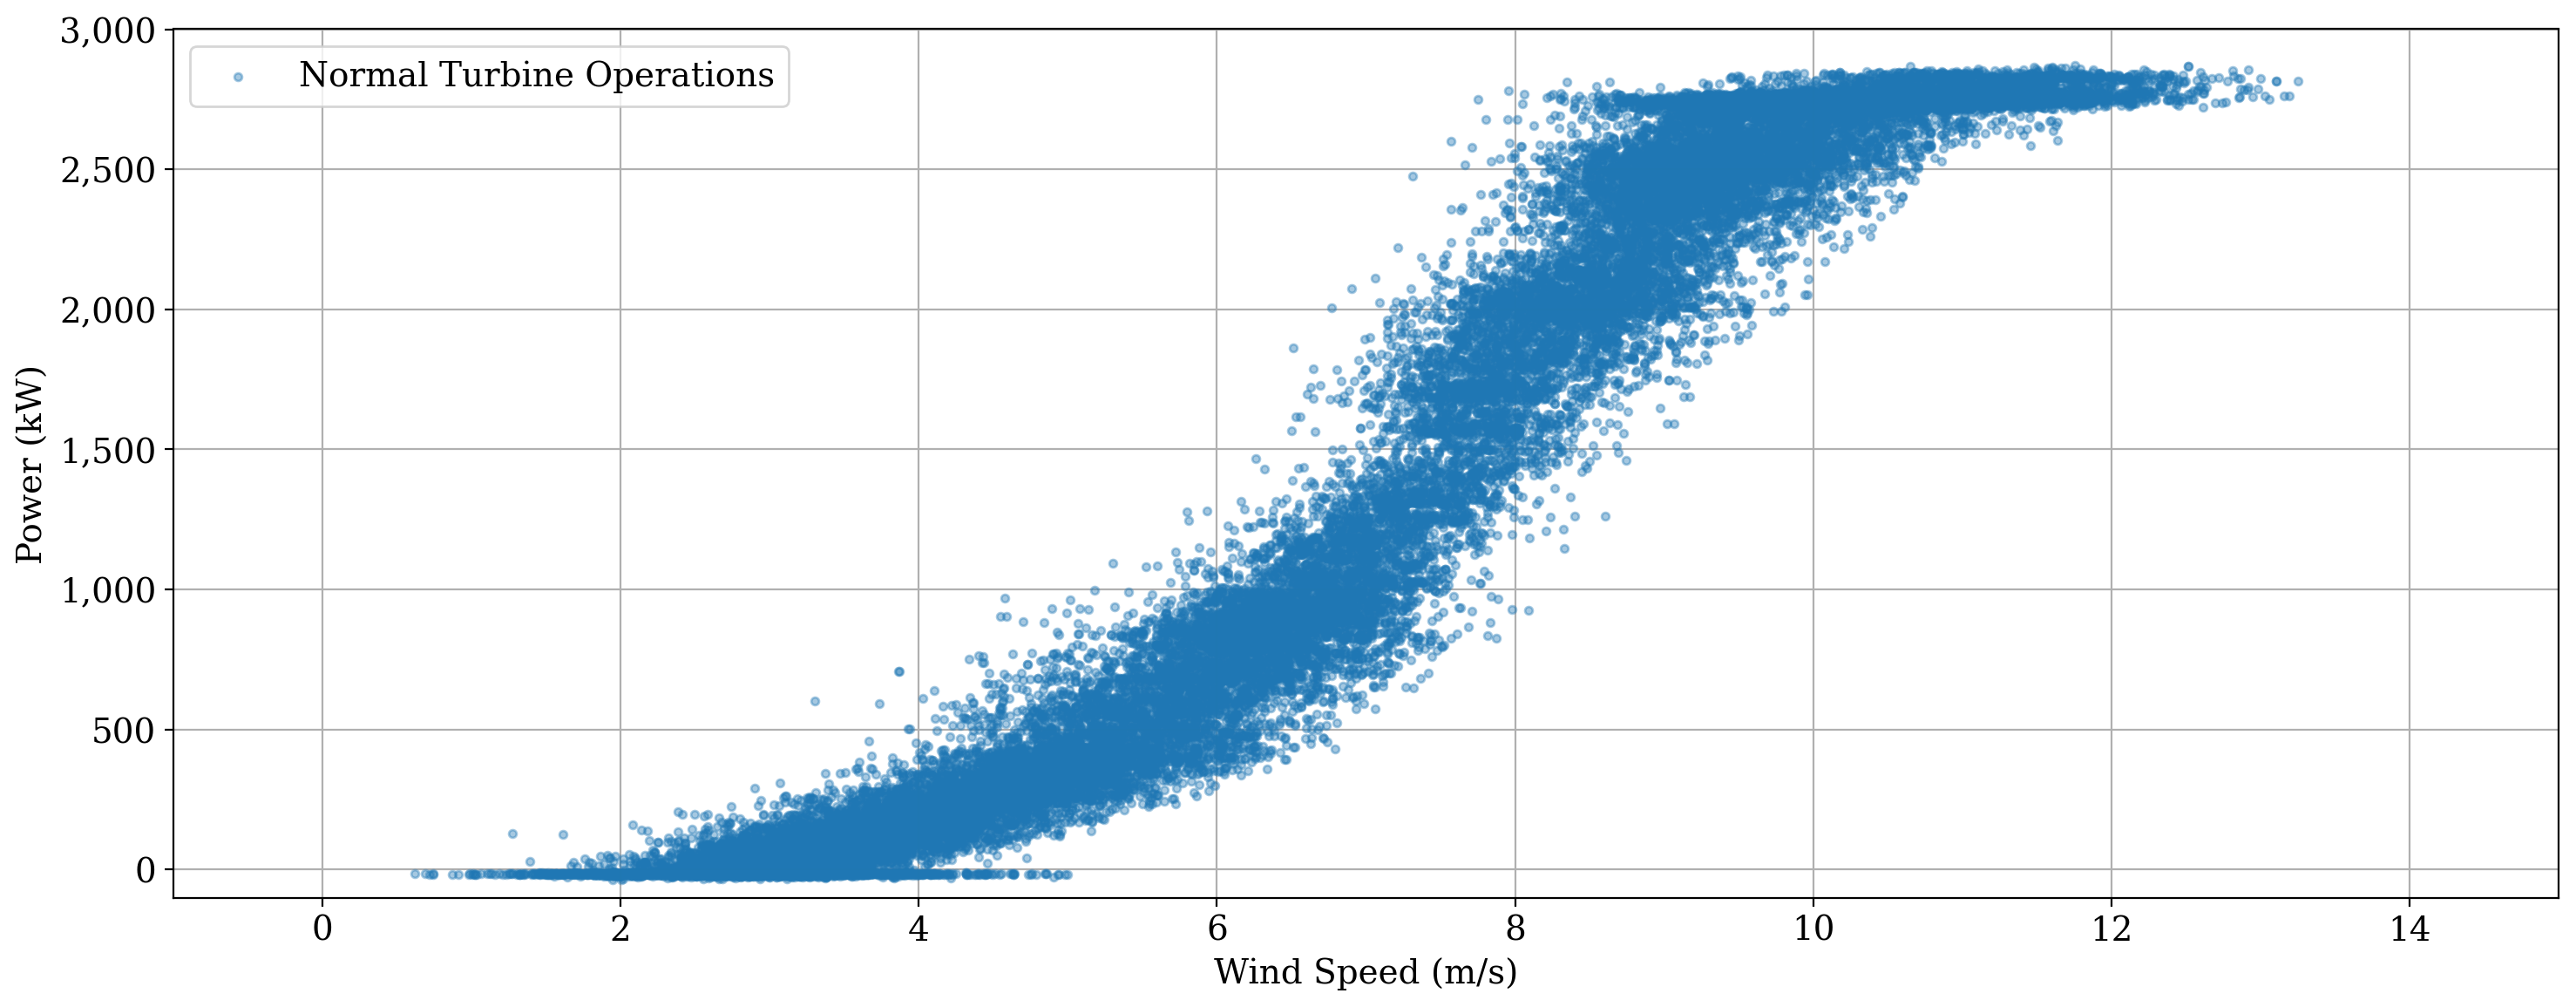

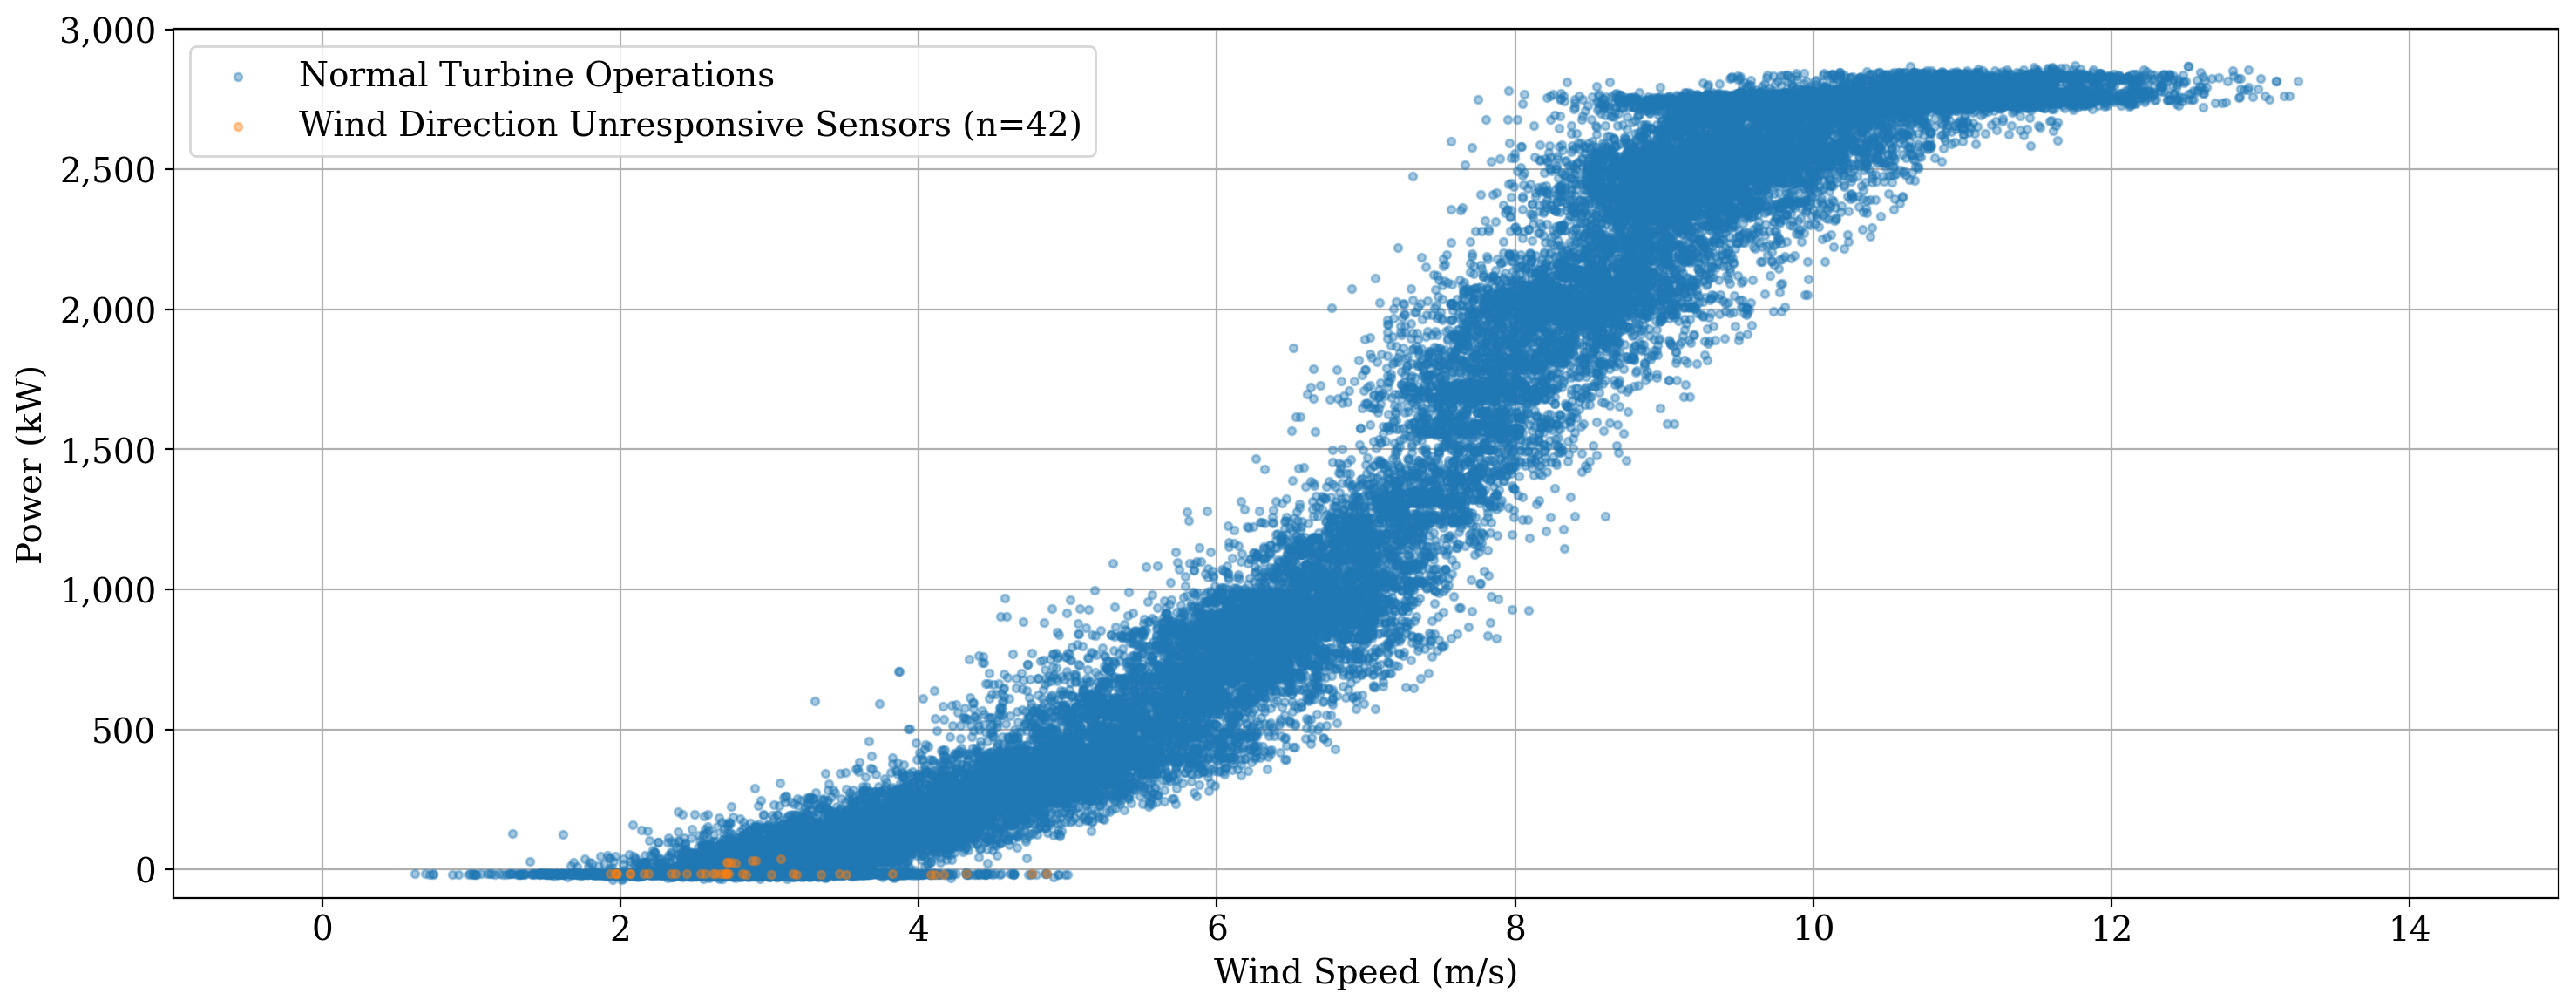

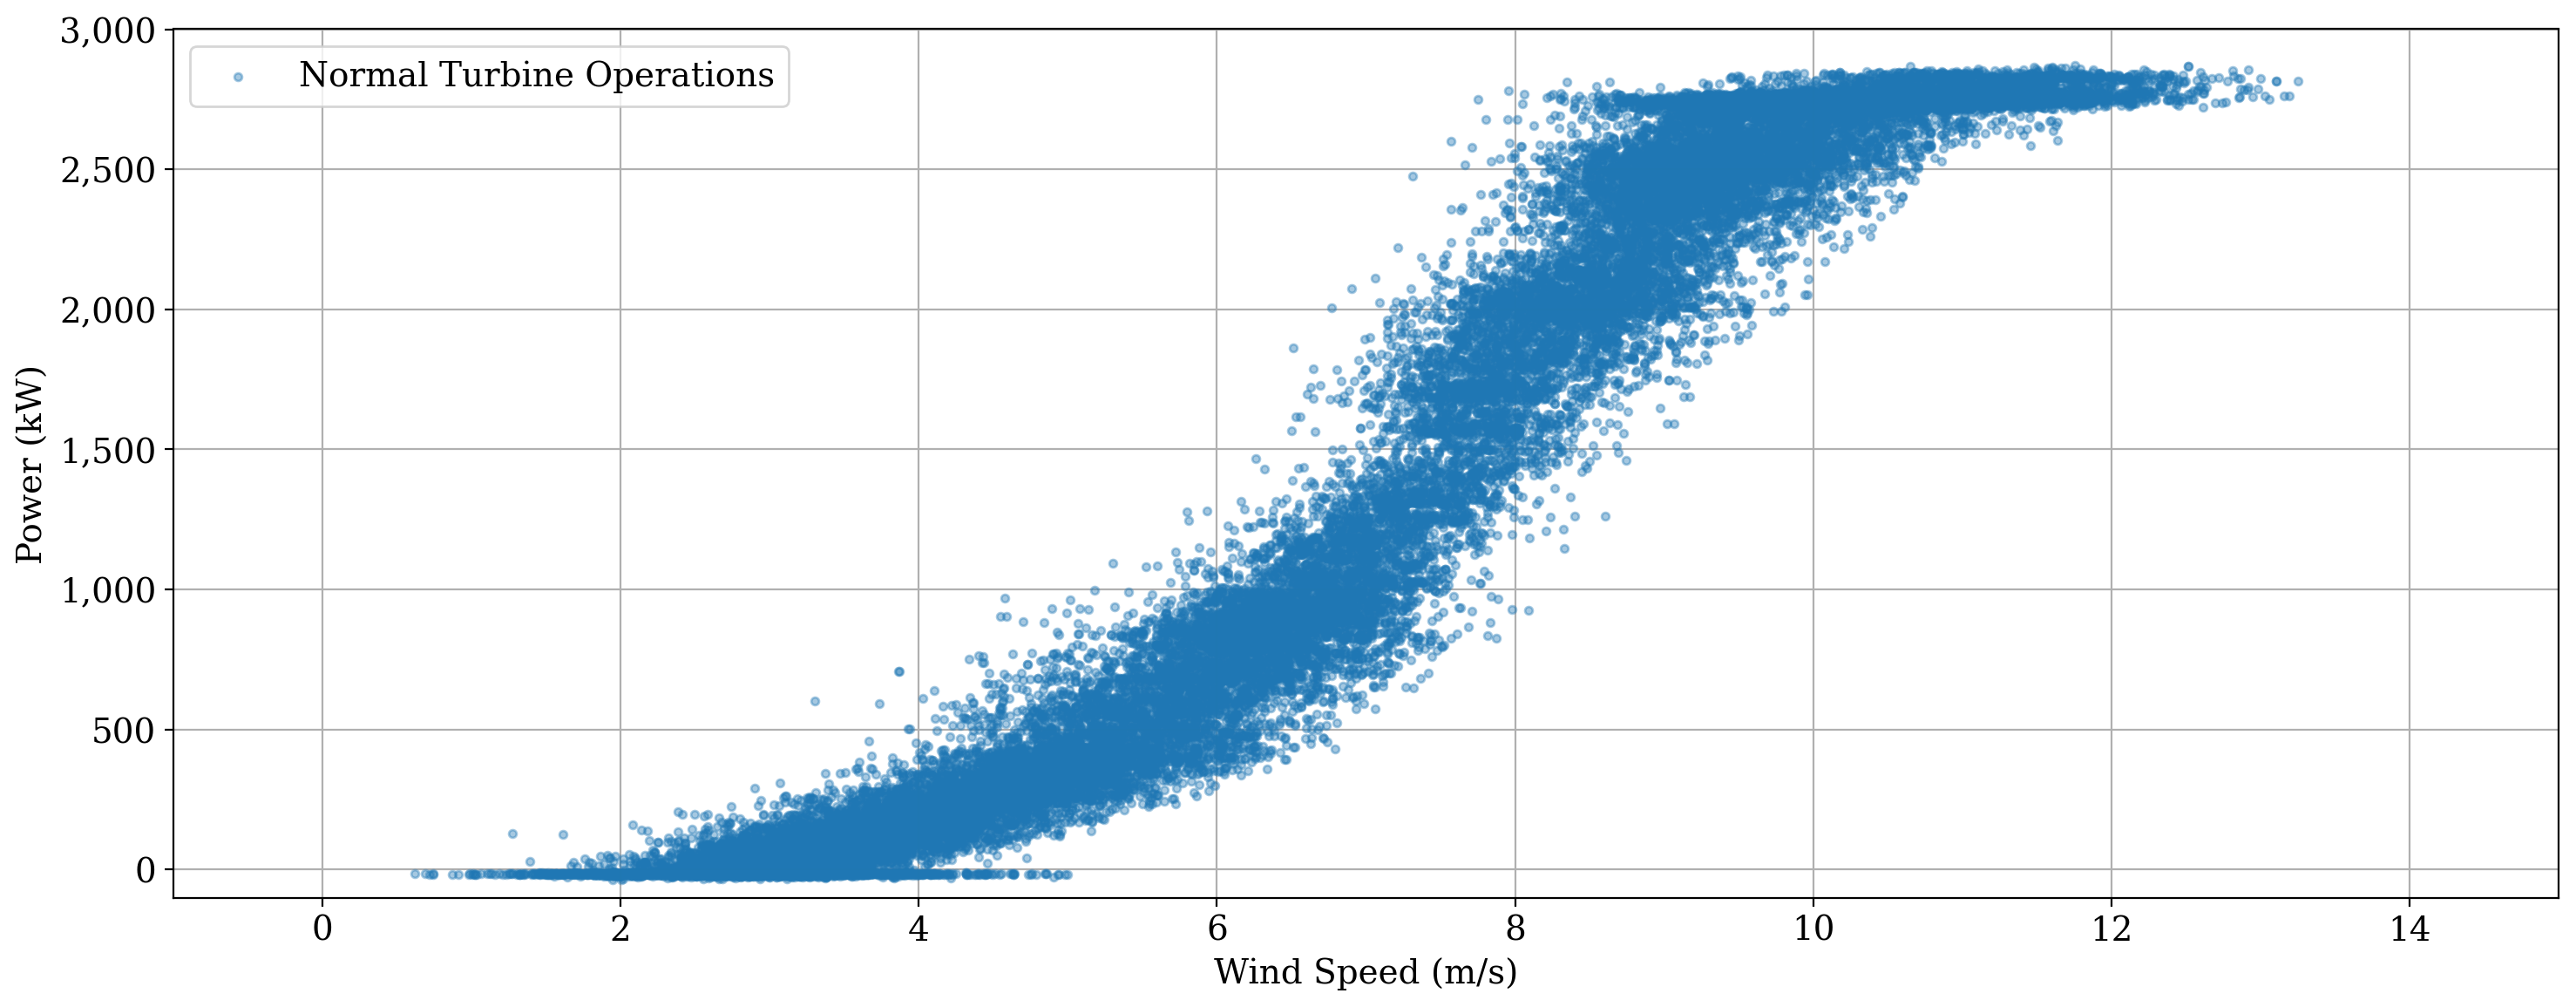

In [26]:
plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=ws_frozen_sensor,
    flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=wd_frozen_sensor,
    flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=pwr_frozen_sensor,
    flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

In [27]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
df = df.with_columns([pl.when(ws_frozen_sensor).then(pl.lit(None)).otherwise(pl.col("wind_speed")).alias("wind_speed"), 
                pl.when(wd_frozen_sensor).then(pl.lit(None)).otherwise(pl.col("wind_direction")).alias("wind_direction"),
                pl.when(pwr_frozen_sensor).then(pl.lit(None)).otherwise(pl.col("power_output")).alias("power_output")
                ])

data_filter.df = df
df = data_filter.resolve_missing_data(features=["wind_speed", "wind_direction", "power_output"])
df

In [28]:
df

shape: (34_430, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time       ┆ turbine_id ┆ turbine_st ┆ turbine_a ┆ wind_dire ┆ wind_spee ┆ power_out ┆ nacelle_d │
│ ---        ┆ ---        ┆ atus       ┆ vailabili ┆ ction     ┆ d         ┆ put       ┆ irection  │
│ datetime[n ┆ str        ┆ ---        ┆ ty        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ s]         ┆            ┆ f64        ┆ ---       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│            ┆            ┆            ┆ f64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 6.374405  ┆ 933.7757  ┆ null      │
│ 00:00:01.4 ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 257.0     ┆ 6.460418  ┆ 941.40848 ┆ null      │
│ 00:00:05.0 ┆            ┆            ┆           ┆           ┆           ┆ 9         ┆           │
│ 46         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 255.04969 ┆ 6.519901  ┆ 946.6871  ┆ null      │
│ 00:00:07.4 ┆            ┆            ┆           ┆ 2         ┆           ┆           ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 253.0     ┆ 6.460303  ┆ 946.13715 ┆ null      │
│ 00:00:10.0 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 77         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 252.13192 ┆ 6.358075  ┆ 945.19384 ┆ null      │
│ 00:00:14.4 ┆            ┆            ┆           ┆           ┆           ┆ 8         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …          ┆ …         ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.12719 ┆ 5.29072   ┆ 401.44371 ┆ null      │
│ 23:59:51.4 ┆            ┆            ┆           ┆ 3         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 240.0     ┆ 5.29024   ┆ 401.66501 ┆ null      │
│ 23:59:51.8 ┆            ┆            ┆           ┆           ┆           ┆ 7         ┆           │
│ 18         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 238.99441 ┆ 5.287711  ┆ 402.83117 ┆ null      │
│ 23:59:53.4 ┆            ┆            ┆           ┆ 7         ┆           ┆ 7         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ 237.0     ┆ 5.282694  ┆ 398.37388 ┆ null      │
│ 23:59:56.8 ┆            ┆            ┆           ┆           ┆           ┆ 5         ┆           │
│ 33         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
│ 2022-03-01 ┆ wt073      ┆ null       ┆ null      ┆ null      ┆ 5.280187  ┆ 396.14657 ┆ null      │
│ 23:59:58.4 ┆            ┆            ┆           ┆           ┆           ┆ 6         ┆           │
│ 99         ┆            ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

### Power Curve Fitting

In [32]:
# Fit the power curves
ws = df["wind_speed"].to_pandas()
pwr = df["power_output"].to_pandas()
iec_curve = power_curve.IEC(ws, pwr)
l5p_curve = power_curve.logistic_5_parametric(ws, pwr)
spline_curve = power_curve.gam(ws, pwr, n_splines=20)

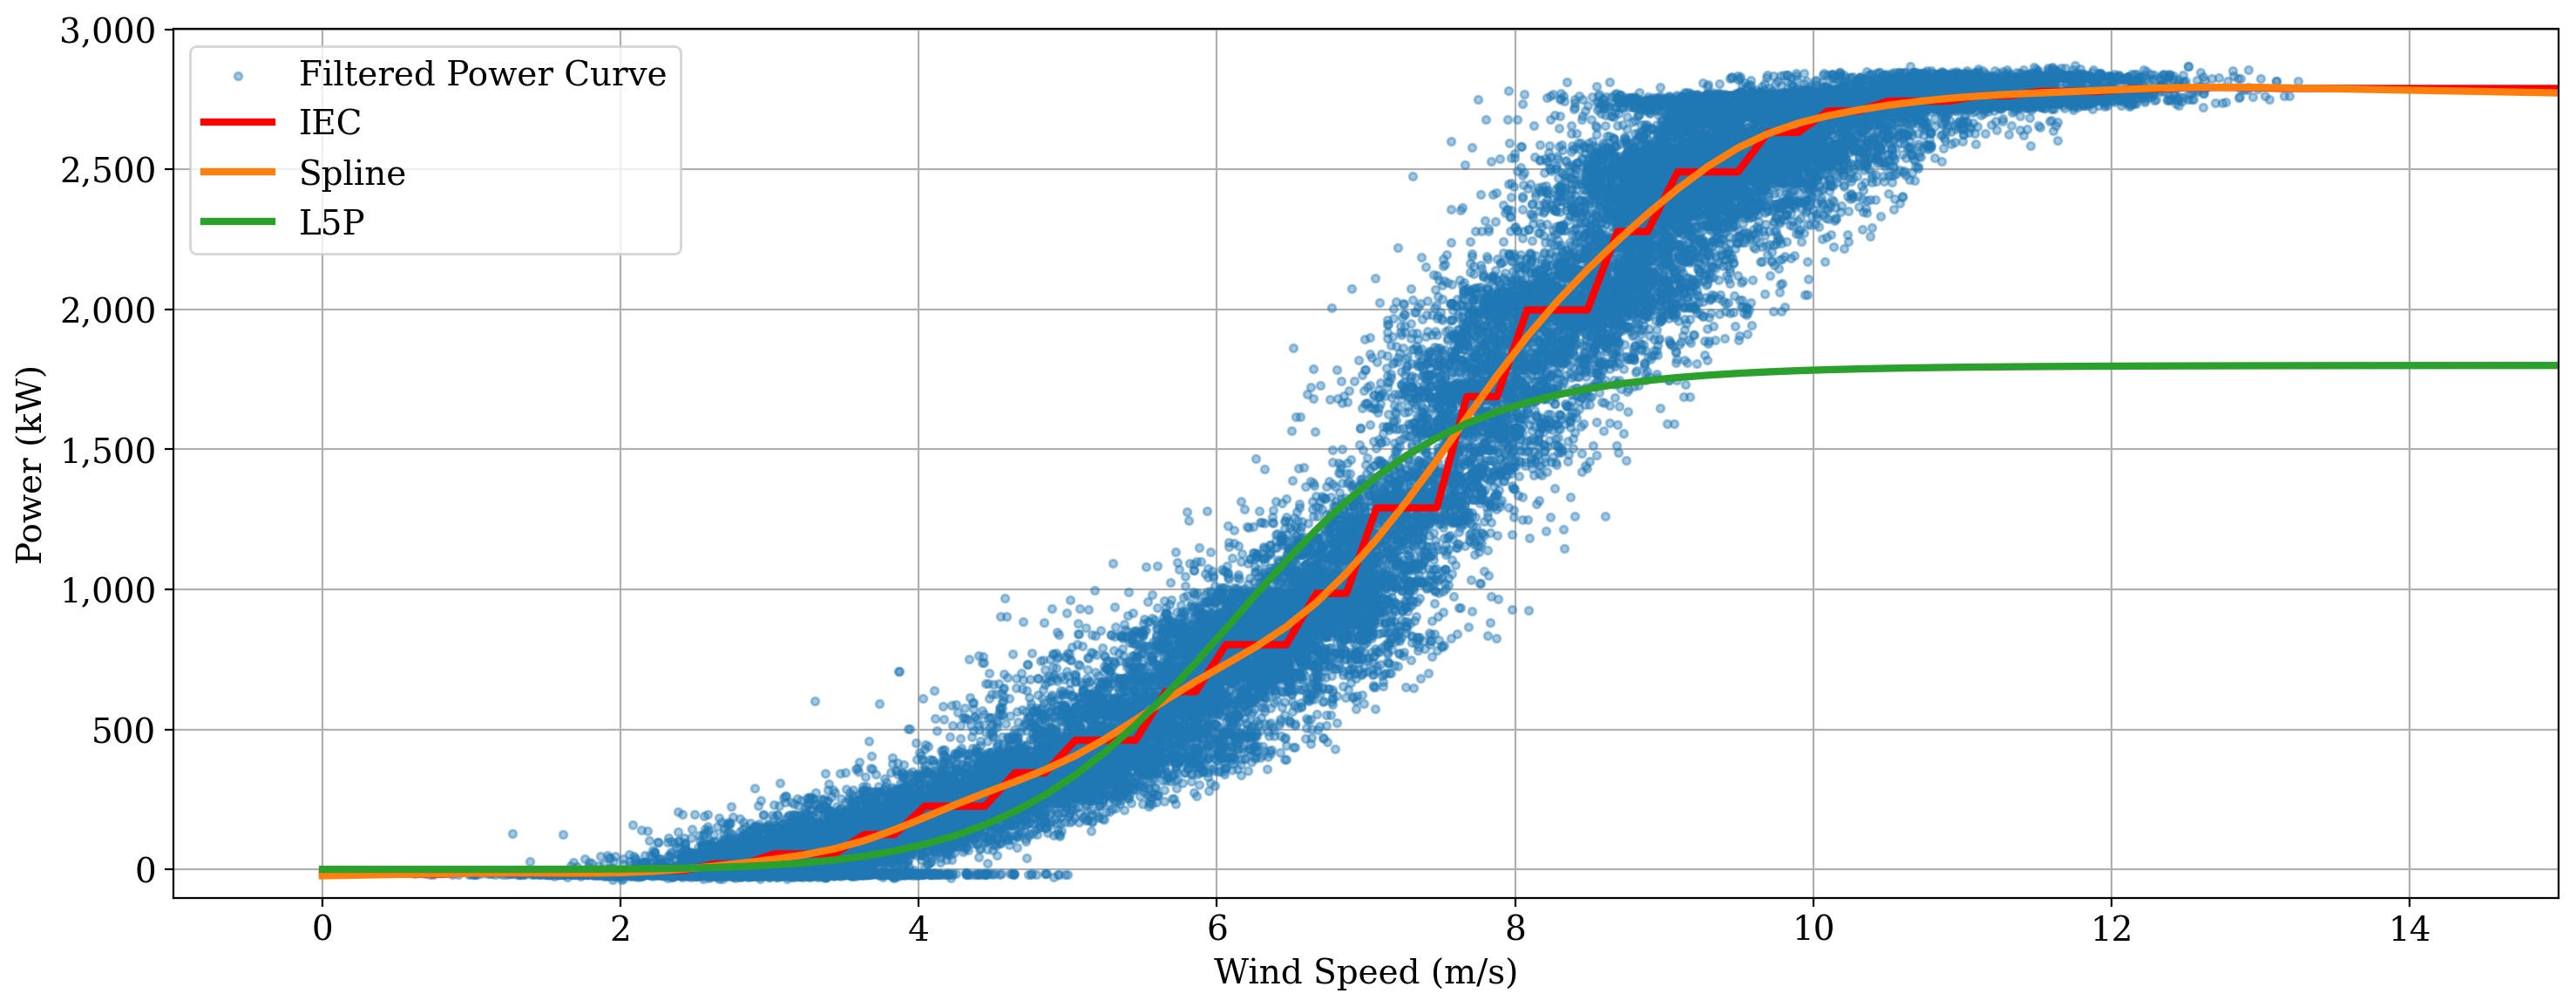

In [33]:
fig, ax = plot.plot_power_curve(
    ws,
    pwr,
    flag=np.zeros(ws.shape, dtype=bool),
    flag_labels=("", "Filtered Power Curve"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=False,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
    return_fig=True,
)

x = np.linspace(0, 20, 100)
ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

ax.legend()

fig.tight_layout()
plt.show()